In [2]:

import tensorflow as tf
import pandas as pd
import os
import datetime
from tensorboard.plugins import projector
import tensorflow_decision_forests as tfdf
import keras_nlp
#import tensorflow_text as text
## Load in data
tf.config.set_visible_devices([], 'GPU')
#sess = tf.Session(config=config)
# tickets = pd.read_csv("master_dataset.csv")


2023-07-28 11:54:39.760639: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


2023-07-28 11:54:42.282215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-28 11:54:42.301513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-28 11:54:42.301549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [7]:
tickets1 = pd.read_csv("master_dataset_clean.csv", skip_blank_lines = False, keep_default_na=False)
#tickets = pd.read_csv("combined_dataset2.csv")
tickets1 = tickets1.fillna('[UNK]')
vocab = pd.read_csv("reduced_vocabulary.csv")
#vocab = vocab['word'].tolist()
encodings = []
#efforts = tickets['effort(s)']
vocab = list(vocab['word'])
descs = tickets1['desc']





In [8]:

## Gather training data
from sklearn.model_selection import train_test_split
labels = pd.read_csv("labelled_dataset.csv")

labels = labels['Grade'].tolist()
labels = [(label - 1)/2 for label in labels]
tickets3 = pd.DataFrame()


text_column = tickets1['desc']
tickets3 = pd.concat([tickets3,text_column], axis = 1)
#label_column = labels['effort(s)'].astype(int)
tickets3['effort'] = labels
#tickets3 = pd.concat([tickets3,labels], axis = 1)



# simplify data ~ 10000
df_low_effort = tickets3[tickets3.effort == 0.0].sample(19000)
df_med_effort = tickets3[tickets3.effort == 0.5].sample(19000)
df_hig_effort = tickets3[tickets3.effort == 1.0].sample(19000)

# print(len(df_low_effort))
# print(len(df_med_effort))
# print(len(df_hig_effort))

result_df = pd.concat([df_low_effort, df_med_effort, df_hig_effort], axis=0)
text_column = result_df['desc']
label_column = result_df['effort']

#xtrain, xtest, ytrain, ytest = train_test_split(descs,labels, test_size=0.2, shuffle=True)
xtrain, xtest, ytrain, ytest = train_test_split(text_column,label_column, test_size=0.2, shuffle=True)


train = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
test = tf.data.Dataset.from_tensor_slices((xtest,ytest))




In [21]:


encoder = tf.keras.layers.TextVectorization(
    max_tokens=len(vocab)+2,
    vocabulary = vocab,
    output_sequence_length = 256,
    output_mode='int'
    #standardize = None
    #dtype=tf.string
    )

def format_dataset(sentence, label):

    sentence = int((encoder(sentence)))
    return (sentence, label)




def make_dataset(dataset):
    #dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(512).map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE) #dataset.batch(64).shuffle(256).prefetch(tf.data.AUTOTUNE).cache()

full_train_ds = make_dataset(train)

test_ds = make_dataset(test)


In [23]:
tuner = tfdf.tuner.RandomSearch(num_trials=20)
tuner.choice("max_depth", [4, 5, 6, 7])


In [24]:
## SETUP NEURAL NETWORK

from tensorflow import keras

model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
#model = tfdf.keras.GradientBoostedTreesModel(num_trees=500)
model.compile(metrics=['accuracy','loss','mse'])




Use /tmp/tmpvruv_ou1 as temporary training directory


[WARNING 23-07-28 10:26:21.9222 PDT gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-28 10:26:21.9222 PDT gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-28 10:26:21.9222 PDT gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [25]:
#model.fit(x=batch_size,y=time_steps)
model.fit(full_train_ds)



Reading training dataset...
Training dataset read in 0:00:02.169303. Found 70388 examples.
Training model...
Model trained in 0:06:12.997606
Compiling model...


[INFO 23-07-28 10:32:40.4912 PDT kernel.cc:1243] Loading model from path /tmp/tmpvruv_ou1/model/ with prefix 6839e5bacfcf4648
[INFO 23-07-28 10:32:40.5009 PDT abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-28 10:32:40.5009 PDT kernel.cc:1075] Use fast generic engine


Model compiled.


In [26]:
model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (256):
	data:0.0
	data:0.1
	data:0.10
	data:0.100
	data:0.101
	data:0.102
	data:0.103
	data:0.104
	data:0.105
	data:0.106
	data:0.107
	data:0.108
	data:0.109
	data:0.11
	data:0.110
	data:0.111
	data:0.112
	data:0.113
	data:0.114
	data:0.115
	data:0.116
	data:0.117
	data:0.118
	data:0.119
	data:0.12
	data:0.120
	data:0.121
	data:0.122
	data:0.123
	data:0.124
	data:0.125
	data:0.126
	data:0.127
	data:0.128
	data:0.129
	data:0.13
	data:0.130
	data:0.131
	data:0.132
	data:0.133
	data:0.134
	data:0.135
	data:0.136
	data:0.137
	data:0.138
	data:0.139
	data:0.14
	data:0.140
	data:0.141
	data:0.142
	data:0.143
	data:0

In [28]:
model.evaluate(test_ds)

ValueError: in user code:

    File "/home/birdy/Repos/Jira_Oracle/.venv/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core_inference.py", line 546, in test_function  *
        return step_function_trained(self, iterator)
    File "/home/birdy/Repos/Jira_Oracle/.venv/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core_inference.py", line 525, in run_step  *
        outputs = model.test_step(data)
    File "/home/birdy/Repos/Jira_Oracle/.venv/lib/python3.11/site-packages/keras/engine/training.py", line 1791, in test_step  **
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/birdy/Repos/Jira_Oracle/.venv/lib/python3.11/site-packages/keras/engine/training.py", line 1149, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/birdy/Repos/Jira_Oracle/.venv/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "/home/birdy/Repos/Jira_Oracle/.venv/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "/home/birdy/Repos/Jira_Oracle/.venv/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/birdy/Repos/Jira_Oracle/.venv/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/birdy/Repos/Jira_Oracle/.venv/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 650, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "/home/birdy/Repos/Jira_Oracle/.venv/lib/python3.11/site-packages/keras/metrics/__init__.py", line 204, in get
        return deserialize(str(identifier))
    File "/home/birdy/Repos/Jira_Oracle/.venv/lib/python3.11/site-packages/keras/metrics/__init__.py", line 158, in deserialize
        return deserialize_keras_object(
    File "/home/birdy/Repos/Jira_Oracle/.venv/lib/python3.11/site-packages/keras/saving/legacy/serialization.py", line 543, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: 'loss'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [29]:
# List of metrics
logs = model.make_inspector().training_logs()
print(logs)


[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=None, accuracy=0.7764037251472473, loss=1.060519814491272, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=2, evaluation=Evaluation(num_examples=None, accuracy=0.7764037251472473, loss=1.058348298072815, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=3, evaluation=Evaluation(num_examples=None, accuracy=0.7764037251472473, loss=1.056071400642395, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=4, evaluation=Evaluation(num_examples=None, accuracy=0.7764037251472473, loss=1.0548124313354492, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=5, evaluation=Evaluation(num_examples=None, accuracy=0.7764037251472473, loss=1.0535961389541626, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=6, evaluation=Evaluation(num_examples=None, accuracy=0.7764037251472473, loss=1.0522925853729248, rmse=None, ndcg

In [35]:
inspector = model.make_inspector()
inspector.variable_importances()


{'INV_MEAN_MIN_DEPTH': [("data:0.1" (1; #2), 0.22382060451020297),
  ("data:0.0" (1; #1), 0.22265867278340493),
  ("data:0.2" (1; #113), 0.21438853540192818),
  ("data:0.3" (1; #180), 0.2138417611161478),
  ("data:0.8" (1; #235), 0.21333221732596663),
  ("data:0.4" (1; #191), 0.21293446944657246),
  ("data:0.17" (1; #80), 0.21268409475910177),
  ("data:0.6" (1; #213), 0.21175142283683987),
  ("data:0.26" (1; #176), 0.21144472400653616),
  ("data:0.5" (1; #202), 0.21136447139236098),
  ("data:0.10" (1; #3), 0.21121235811501934),
  ("data:0.11" (1; #14), 0.20978469236292915),
  ("data:0.16" (1; #69), 0.20949159994163424),
  ("data:0.7" (1; #224), 0.2093518538989903),
  ("data:0.9" (1; #246), 0.2090770863047577),
  ("data:0.15" (1; #58), 0.2089765155942636),
  ("data:0.30" (1; #181), 0.20868571939153155),
  ("data:0.56" (1; #209), 0.20865536250679806),
  ("data:0.27" (1; #177), 0.2084487445268707),
  ("data:0.14" (1; #47), 0.20843230162685894),
  ("data:0.46" (1; #198), 0.2084173234602293

In [31]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)


In [36]:
tree = inspector.extract_tree(tree_idx=0)
print(tree)


(data:0.38 >= 0.5; miss=True, score=0.0013401360483840108)
    ├─(pos)─ (data:0.85 >= 3.0; miss=True, score=0.0010456054005771875)
    │        ├─(pos)─ (data:0.1 >= 2657.5; miss=False, score=0.0023256191052496433)
    │        │        ├─(pos)─ (data:0.1 >= 2660.0; miss=False, score=0.07248437404632568)
    │        │        │    ...
    │        │        └─(neg)─ (data:0.131 >= 1333.0; miss=False, score=0.0013310349313542247)
    │        │             ...
    │        └─(neg)─ (data:0.29 >= 2.5; miss=True, score=0.0006158690084703267)
    │                 ├─(pos)─ (data:0.6 >= 4.5; miss=True, score=0.0005062871496193111)
    │                 │    ...
    │                 └─(neg)─ (data:0.39 >= 2090.0; miss=False, score=0.001988633768633008)
    │                      ...
    └─(neg)─ (data:0.20 >= 407.0; miss=True, score=0.00021837367967236787)
             ├─(pos)─ (data:0.1 >= 1604.0; miss=False, score=0.0003597891773097217)
             │        ├─(pos)─ (data:0.18 >= 2326.0; 

In [33]:
model.get_metrics_result()


{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [37]:
inspector.num_trees()

300

In [41]:
inspector.evaluation()


Evaluation(num_examples=None, accuracy=0.7809523940086365, loss=1.0242301225662231, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

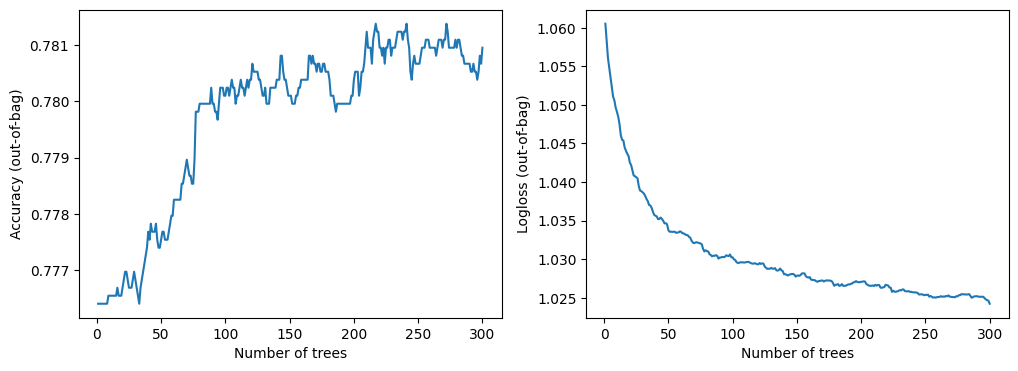

In [42]:
import matplotlib.pyplot as plt

logs = inspector.training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()


In [ ]:
model_69 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=8,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM",
    )
model_69.fit(full_train_ds)


In [3]:
#DO REGRESSHI

tickets1 = pd.read_csv("master_dataset_clean.csv", skip_blank_lines = False, keep_default_na=False)
tickets = pd.read_csv("encodings_and_effort.csv")
tickets1 = tickets1.fillna('[UNK]')
vocab = pd.read_csv("reduced_vocabulary.csv")
#vocab = vocab['word'].tolist()
encodings = []
efforts = list(tickets['effort'])
vocab = list(vocab['word'])
descs = tickets1['desc']



## Gather training data
from sklearn.model_selection import train_test_split
labels = pd.read_csv("labelled_dataset.csv")

labels = labels['Grade'].tolist()
labels = [(label - 1)/2 for label in labels]
tickets3 = pd.DataFrame()


text_column = tickets1['desc']
tickets3 = pd.concat([tickets3,text_column], axis = 1)
#label_column = labels['effort(s)'].astype(int)
tickets3['effort'] = efforts
tickets3['label'] = labels
#tickets3 = pd.concat([tickets3,labels], axis = 1)



# simplify data ~ 10000
df_low_effort = tickets3[tickets3.label == 0.0].sample(30000)
df_med_effort = tickets3[tickets3.label == 0.5].sample(30000,replace=True)
df_hig_effort = tickets3[tickets3.label == 1.0].sample(30000,replace=True)

# print(len(df_low_effort))
# print(len(df_med_effort))
# print(len(df_hig_effort))

result_df = pd.concat([df_low_effort, df_med_effort, df_hig_effort], axis=0)
text_column = result_df['desc']
label_column = result_df['effort']

xtrain, xtest, ytrain, ytest = train_test_split(text_column,label_column, test_size=0.2, shuffle=True)

train = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
test = tf.data.Dataset.from_tensor_slices((xtest,ytest))



In [4]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=len(vocab)+2,
    vocabulary = vocab,
    output_sequence_length = 256,
    output_mode='int'
    #standardize = None
    #dtype=tf.string
    )

def format_dataset(sentence, label):

    sentence = int((encoder(sentence)))
    return (sentence, label)




def make_dataset(dataset):
    #dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(512).map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE) #dataset.batch(64).shuffle(256).prefetch(tf.data.AUTOTUNE).cache()

full_train_ds = make_dataset(train)

test_ds = make_dataset(test)

In [5]:
tuner = tfdf.tuner.RandomSearch(num_trials=20)
tuner.choice("max_depth", [4, 5, 6, 7, 8, 9])
#randomforest?
mode_reg = tfdf.keras.GradientBoostedTreesModel(num_trees=500,
                                                task = tfdf.keras.Task.REGRESSION,
                                                tuner=tuner)

# model_69 = tfdf.keras.GradientBoostedTreesModel(
#     task = tfdf.keras.Task.REGRESSION,
#     num_trees=500,
#     growing_strategy="BEST_FIRST_GLOBAL",
#     max_depth=8,
#     split_axis="SPARSE_OBLIQUE",
#     categorical_algorithm="RANDOM",
#     )



#model = tfdf.keras.GradientBoostedTreesModel(num_trees=500)
#mode_reg.compile(metrics=['mse','accuracy'])

Use /tmp/tmpj_dk61fj as temporary training directory


[WARNING 23-07-28 11:55:04.5152 PDT gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-28 11:55:04.5153 PDT gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-28 11:55:04.5153 PDT gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [6]:
#mode_reg.fit(full_train_ds)
mode_reg.fit(full_train_ds)

Reading training dataset...


Training dataset read in 0:00:03.918732. Found 72000 examples.
Training model...
Training model...


In [75]:
mode_reg.evaluate(test_ds)

35/35 [==============================] - 0s 4ms/step - loss: 0.0000e+00


0.0

In [76]:
inspector = mode_reg.make_inspector()

In [77]:
inspector.evaluation()

Evaluation(num_examples=None, accuracy=None, loss=55677.9453125, rmse=55677.9453125, ndcg=None, aucs=None, auuc=None, qini=None)

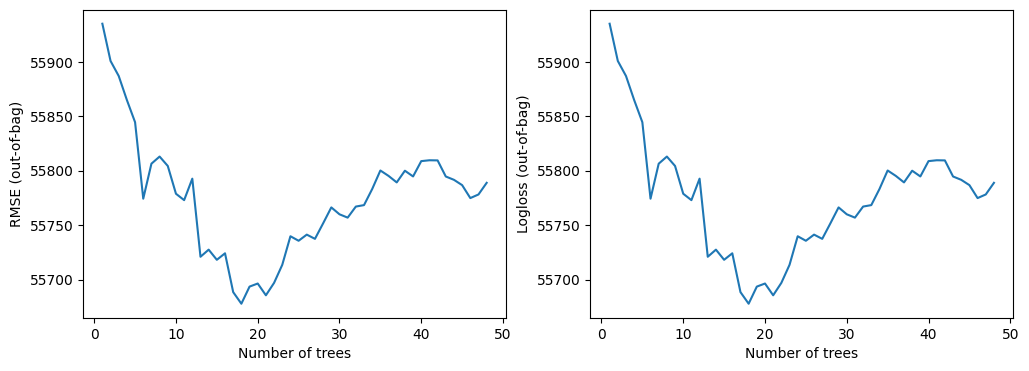

In [78]:
import matplotlib.pyplot as plt

logs = inspector.training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()


In [79]:
inspector.variable_importances()

{'INV_MEAN_MIN_DEPTH': [("data:0.101" (1; #5), 0.351369061738105),
  ("data:0.196" (1; #109), 0.17760544336686626),
  ("data:0.133" (1; #40), 0.17104043340980604),
  ("data:0.172" (1; #83), 0.16994492406087106),
  ("data:0.0" (1; #1), 0.1692672840917696),
  ("data:0.63" (1; #217), 0.16374794661366457),
  ("data:0.134" (1; #41), 0.16051097456907157),
  ("data:0.39" (1; #190), 0.15964933040525198),
  ("data:0.59" (1; #212), 0.15837469489668532),
  ("data:0.41" (1; #193), 0.15453356541220167),
  ("data:0.46" (1; #198), 0.15337066495115803),
  ("data:0.44" (1; #196), 0.15331623939967384),
  ("data:0.132" (1; #39), 0.1529250437041205),
  ("data:0.27" (1; #177), 0.15250629654074663),
  ("data:0.219" (1; #135), 0.15211542589584762),
  ("data:0.65" (1; #219), 0.15206703926421733),
  ("data:0.115" (1; #20), 0.15204866561596667),
  ("data:0.92" (1; #249), 0.15175119346967667),
  ("data:0.2" (1; #113), 0.15135578450903128),
  ("data:0.1" (1; #2), 0.15011975194937918),
  ("data:0.73" (1; #228), 0.